<a href="https://colab.research.google.com/github/silveiraluiza/machine-learning/blob/main/Kmeans_Hierarchical_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
import missingno as msno

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Exploração dos Dados

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/data/datasets_glass.csv', sep=',')

# Visualização dos dados 
print(data.shape)
data.head(10)


(214, 10)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
5,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
6,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
7,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
8,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
9,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [ ]:
data.describe() 

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


Os dados não estão em uma mesma escala numérica, será necessária a normalização.

### Dados nulos

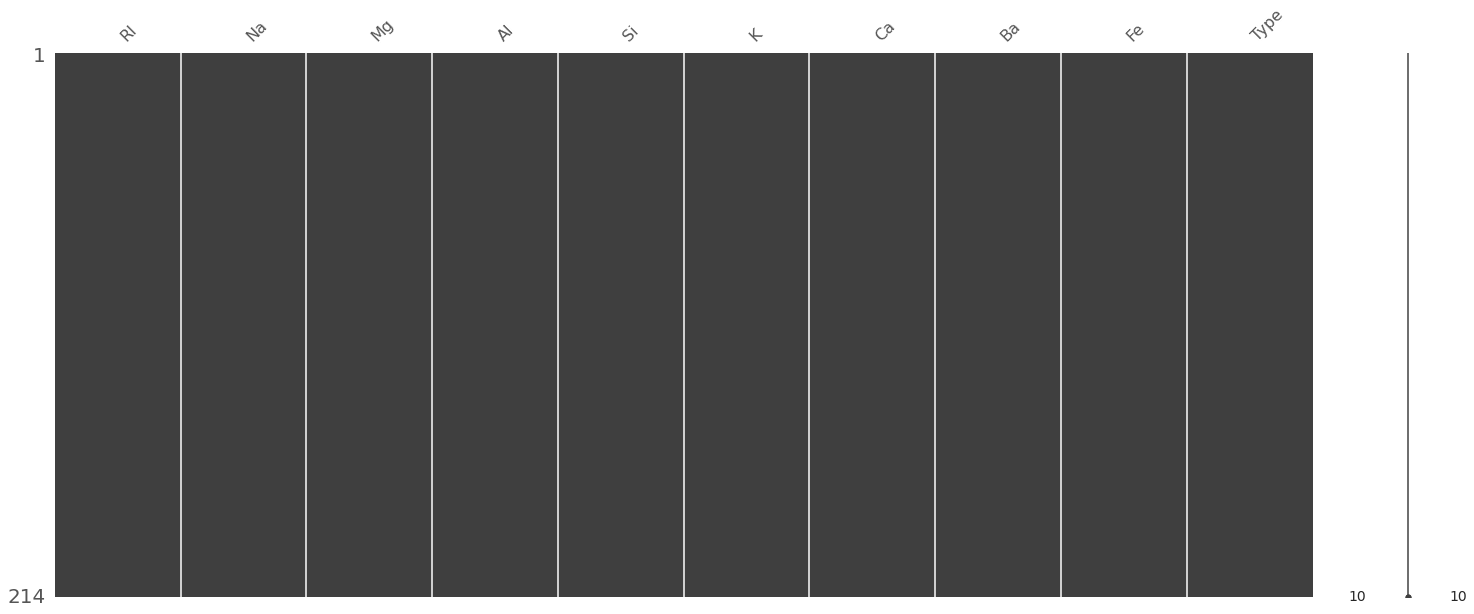

In [ ]:
msno.matrix(data)


Vericamos que não existem dados nulos neste dataset, portanto seguiremos com a normalização dos dados, já que não é necessário o tratamento de nulos.

### Normalização dos dados

A normalização é um redimensionamento dos dados de sua faixa original para que todos os valores estejam dentro da nova faixa de 0 e 1.

A normalização exige que se conheça ou se possa estimar com precisão os valores mínimos e máximos observáveis. Poderá ser capaz de estimar estes valores a partir dos seus dados disponíveis. A normalização dos dados é necessária para que colunas cuja faixa de valores é mais alta do que as outras não sejam intrinsecamente tidas como preditores mais importantes.

In [ ]:
data['Type'] = data['Type'].apply(str)

columns_list = data.columns
features = data.drop("Type", axis=1).values
y = data["Type"].values

# perform a robust scaler transform of the dataset
trans = MinMaxScaler()
scaled = trans.fit_transform(features)
# convert the array back to a dataframe
data = DataFrame(scaled)
data["Type"] = y
data.columns = columns_list

# summarize
print(data.describe())

               RI          Na          Mg  ...          Ca          Ba          Fe
count  214.000000  214.000000  214.000000  ...  214.000000  214.000000  214.000000
mean     0.316744    0.402684    0.597891  ...    0.327785    0.055570    0.111783
std      0.133313    0.122798    0.321249  ...    0.132263    0.157847    0.191056
min      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
25%      0.235843    0.327444    0.471047  ...    0.261152    0.000000    0.000000
50%      0.286655    0.386466    0.775056  ...    0.294610    0.000000    0.000000
75%      0.351514    0.465414    0.801782  ...    0.347816    0.000000    0.196078
max      1.000000    1.000000    1.000000  ...    1.000000    1.000000    1.000000

[8 rows x 9 columns]


### Distribuição das classes

In [ ]:
data["Type"].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

(array([70., 76., 17.,  0., 13.,  9., 29.]),
 array([0.        , 0.71428571, 1.42857143, 2.14285714, 2.85714286,
        3.57142857, 4.28571429, 5.        ]),
 <a list of 7 Patch objects>)

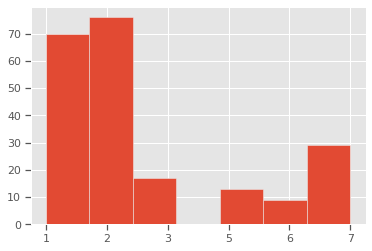

In [ ]:
plt.style.use('ggplot')
plt.hist(data["Type"], bins=7)

Temos 7 classes nesse dataset e sendo elas nomeadas de 1-7, mas não existem exemplos onde a classe 4 é representada. Para fins representativos e comparativos iremos renomear as classes de 0-5. Também podemos observar que as classes são desbalanceadas, sendo a 1 e 2 com mais exemplos representados no dataset.

In [ ]:
data["Type"].loc[data["Type"] == "1"] = "0"
data["Type"].loc[data["Type"] == "2"] = "1"
data["Type"].loc[data["Type"] == "3"] = "2"
data["Type"].loc[data["Type"] == "5"] = "3"
data["Type"].loc[data["Type"] == "6"] = "4"
data["Type"].loc[data["Type"] == "7"] = "5"

data["Type"].value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


1    76
0    70
5    29
2    17
3    13
4     9
Name: Type, dtype: int64

(array([70., 76., 17., 13.,  9., 29.]),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 <a list of 6 Patch objects>)

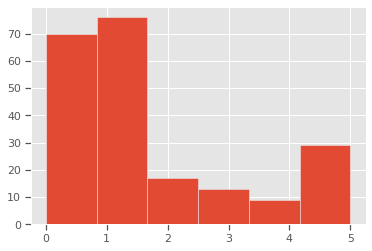

In [ ]:
plt.style.use('ggplot')
plt.hist(data["Type"], bins=6)

### Matriz de correlação

In [ ]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
RI,1.00,-0.19,-0.12,-0.41,-0.54,-0.29,0.81,-0.00,0.14
Na,-0.19,1.00,-0.27,0.16,-0.07,-0.27,-0.28,0.33,-0.24
Mg,-0.12,-0.27,1.00,-0.48,-0.17,0.01,-0.44,-0.49,0.08
Al,-0.41,0.16,-0.48,1.00,-0.01,0.33,-0.26,0.48,-0.07
Si,-0.54,-0.07,-0.17,-0.01,1.00,-0.19,-0.21,-0.10,-0.09
K,-0.29,-0.27,0.01,0.33,-0.19,1.00,-0.32,-0.04,-0.01
Ca,0.81,-0.28,-0.44,-0.26,-0.21,-0.32,1.00,-0.11,0.12
Ba,-0.00,0.33,-0.49,0.48,-0.10,-0.04,-0.11,1.00,-0.06
Fe,0.14,-0.24,0.08,-0.07,-0.09,-0.01,0.12,-0.06,1.00


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 576x576 with 0 Axes>

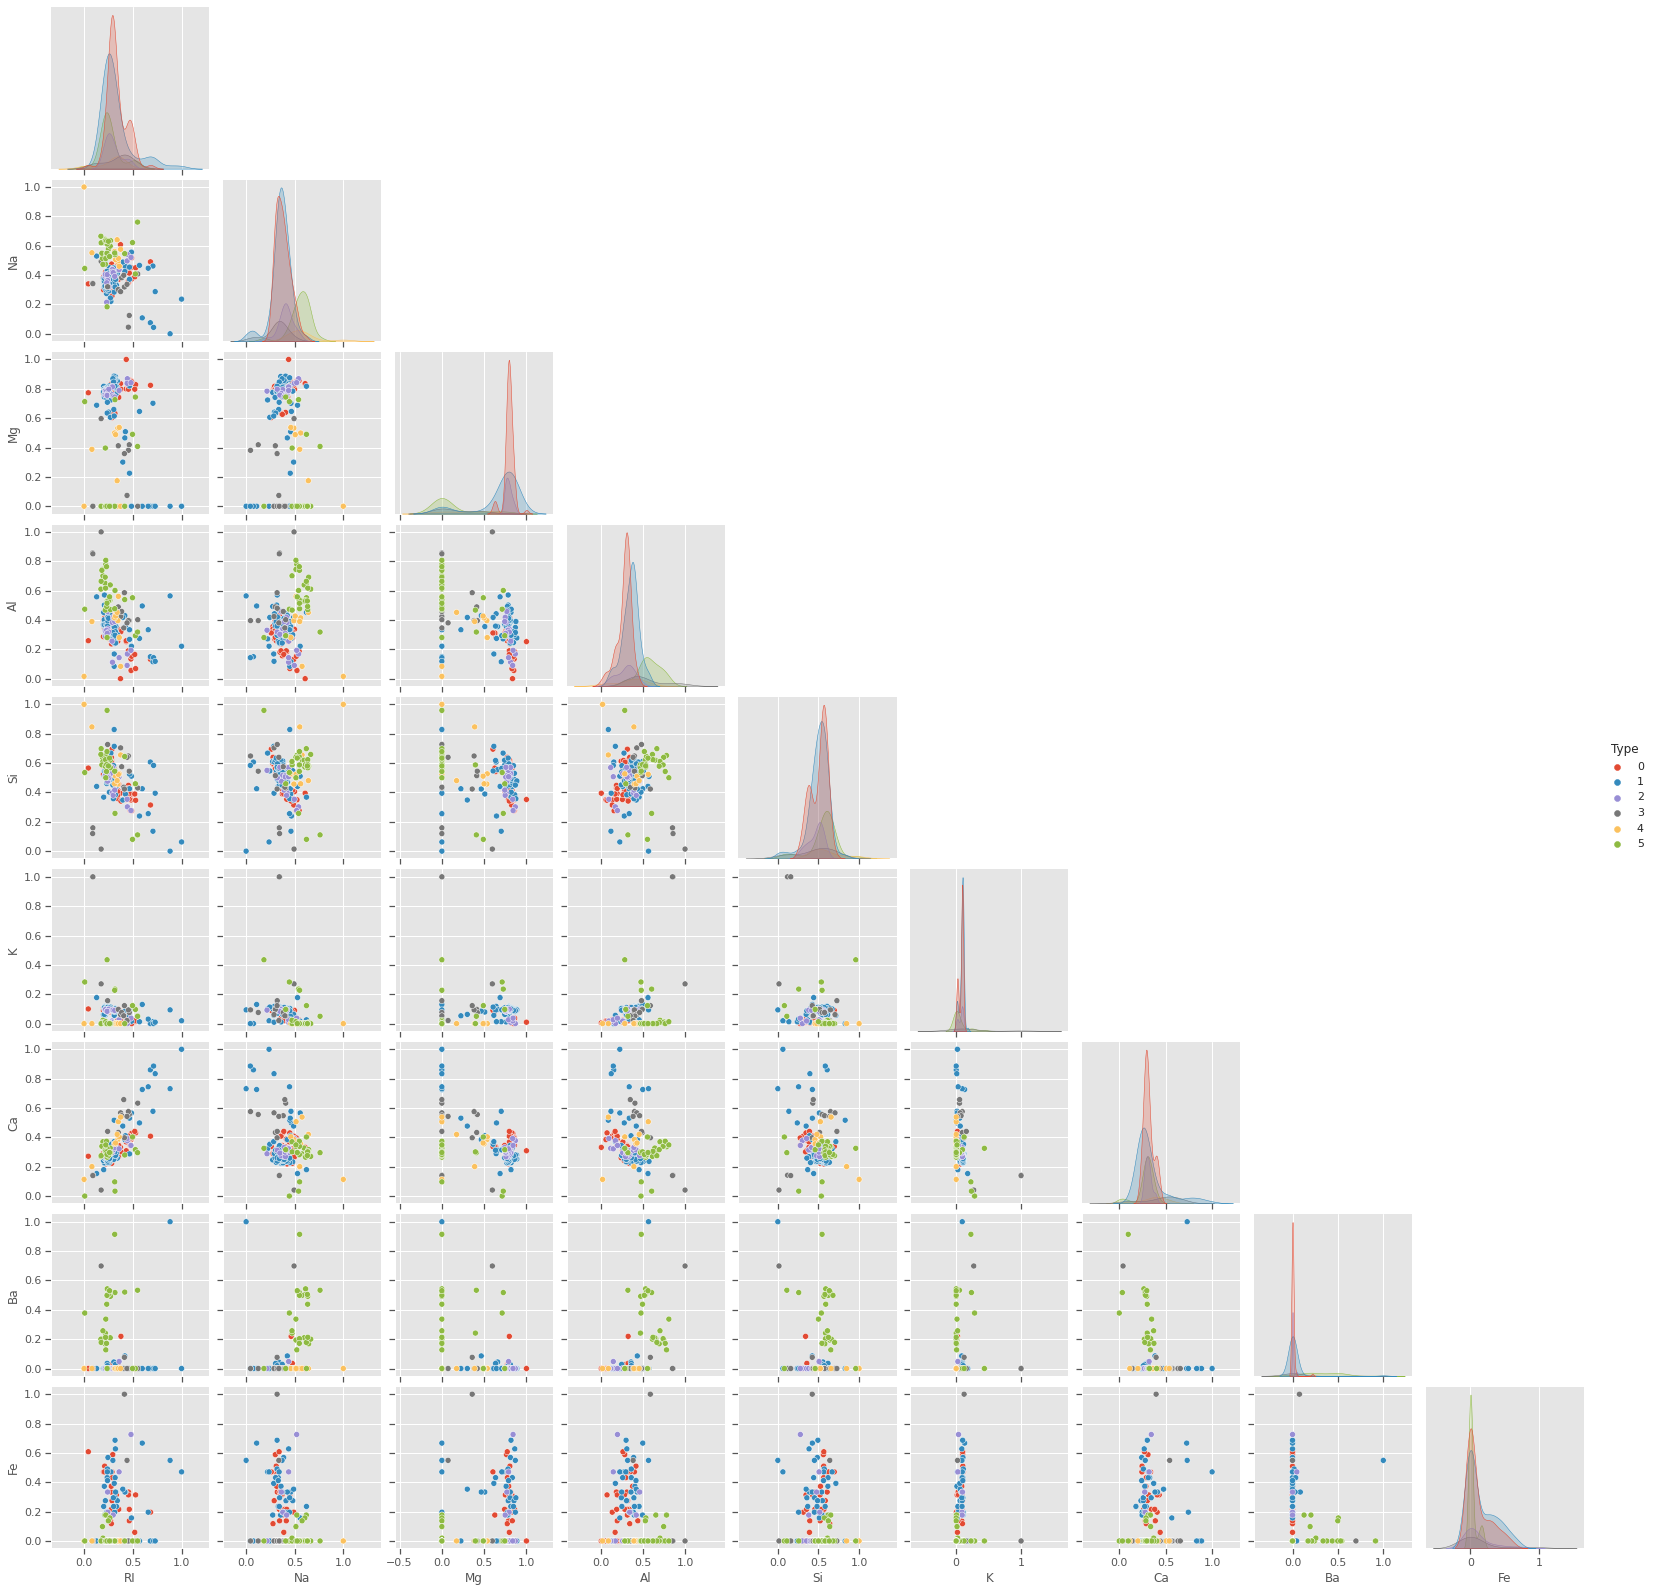

In [ ]:
variaveis_pertinentes = data
sns.set(style="ticks", color_codes=True)
plt.style.use('ggplot')
# Plotando a distribuição em pares das variáveis 
plt.figure(figsize=(8,8))
sns.pairplot(variaveis_pertinentes, hue="Type", corner=True, diag_kind="kde")
plt.show()

## Hierarchical Clustering

Hierarchical clustering é uma família geral de algoritmos de agrupamento que constroem clusters aninhados, fundindo-os ou dividindo-os sucessivamente. Esta hierarquia de clusters é representada como uma árvore (ou dendrograma). A raiz da árvore é o aglomerado único que recolhe todas as amostras, sendo as folhas os aglomerados com apenas uma amostra. 

O AgglomerativeClustering executa um agrupamento hierárquico utilizando uma abordagem ascendente: cada observação começa no seu próprio agrupamento, e os agrupamentos são sucessivamente fundidos.


## K-Means


O KMeans agrupa dados tentando separar amostras em n grupos de igual variância, minimizando um critério conhecido como a inércia ou soma de quadrados dentro de um mesmo grupo. Este algoritmo requer que seja especificado o número de clusters. É escalavel a um grande número de amostras e tem sido utilizado numa vasta gama de áreas de aplicação em muitos campos diferentes.

O Kmeans divide um conjunto de amostras em grupos desarticulados cada um descrito pela média das amostras no aglomerado. As médias são normalmente chamadas de "centroides". O algoritmo visa a escolha de centróides que minimizem a inércia, ou o critério da soma dos quadrados dentro de um mesmo espaço.

A inércia pode ser reconhecida como uma medida da coerência interna dos clusters. Esta possui alguns defeitos:

  - A inércia pressupõe que os aglomerados são convexos e isotrópicos, o que nem sempre é o caso. Responde mal a aglomerados alongados, ou manifolds com formas irregulares.

  - A inércia não é uma métrica normalizada: apenas sabemos que valores mais baixos são melhores e zero é óptimo. Mas em espaços muito elevados, as distâncias euclidianas tendem a tornar-se infladas (este é um exemplo da chamada "maldição da dimensionalidade"). A execução de um algoritmo de redução da dimensionalidade, como a análise de componentes principais (PCA) antes do agrupamento por kmeans, pode aliviar este problema e acelerar os cálculos.




## Elbow Method

Um passo fundamental para qualquer algoritmo não supervisionado é determinar o número ótimo de clusters nos quais os dados podem ser agrupados. O Método do Cotovelo é um dos métodos mais populares para determinar este valor ótimo de k.

Para executar o método do cotovelo definimos agora o seguinte:

  - Distorção: É calculada como a média das distâncias ao quadrado dos centros de agrupamento dos respectivos clusters. Tipicamente, é utilizada a métrica de distância euclidiana.

  - Inércia: É a soma das distâncias ao quadrado das amostras até ao seu centro de aglomerado mais próximo.

Iteramos os valores de k de 1 a 9 e calculamos os valores de distorções para cada valor de k e calculamos a distorção e inércia para cada valor de k no intervalo dado.


In [ ]:
X = data.drop("Type", axis=1).values
y = data["Type"].values


distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_


1 : 0.4511411237596774
2 : 0.3361287653584268
3 : 0.31127488635461603
4 : 0.2691787666358452
5 : 0.2574705928207434
6 : 0.23584133436062105
7 : 0.22891678144037209
8 : 0.21900271344751188
9 : 0.21124208979593675


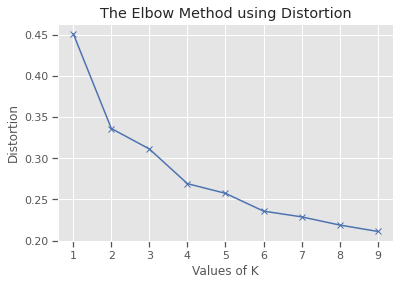

In [ ]:

for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


1 : 57.364221318488575
2 : 34.13198335061759
3 : 28.5852429839316
4 : 23.697477526748116
5 : 21.075767833674032
6 : 18.53571710218324
7 : 16.300211267419083
8 : 14.689019157555396
9 : 13.439503589325172


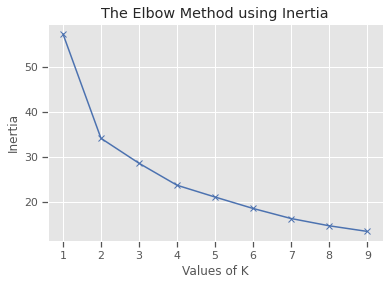

In [ ]:

for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


Para determinar o número ótimo de clusters, temos de seleccionar o valor de k no "cotovelo", ou seja, o ponto após o qual a distorção/inercia começa a diminuir de forma linear. Assim, para os dados fornecidos, concluímos que o número ótimo de aglomerados para os dados é 3 se levarmos em conta o gráfico da distorção e 2 levando em consideração o gráfico da inércia.

## Clusterização

Desse modo iremos variar os valores de k entre 2 e 6 (pois 6 é o número de classes que temos no dataset) e comparar os resultados entre os diferentes ks para o kmeans e o agrupamento hierárquico.

In [ ]:
for k in range(2,7,1):

  kmeans = KMeans(n_clusters=k)
  clustering = AgglomerativeClustering(n_clusters=k)

  y_pred = kmeans.fit_predict(X)
  y_pred_c = clustering.fit_predict(X)

  data['kmeans_' + str(k)] = y_pred
  data['cluster_' + str(k)] = y_pred_c

print(data.head())

         RI        Na        Mg  ...  cluster_5  kmeans_6  cluster_6
0  0.432836  0.437594  1.000000  ...          0         2          5
1  0.283582  0.475188  0.801782  ...          0         3          2
2  0.220808  0.421053  0.790646  ...          0         3          2
3  0.285777  0.372932  0.821826  ...          0         3          2
4  0.275241  0.381955  0.806236  ...          0         3          2

[5 rows x 20 columns]


### Utilizando a clusterização hierárquica sem definir o k

In [ ]:
clustering = AgglomerativeClustering()
y_pred_c = clustering.fit_predict(X)

data['cluster_standalone'] = y_pred_c

In [ ]:
data['cluster_standalone'].value_counts()

1    165
0     49
Name: cluster_standalone, dtype: int64

A clusterização hierárquica definiu que k=2 seria o número ótimo de clusters, assim como a técnica elbow.

In [ ]:
data['cluster_2'] = data['cluster_standalone']
data.drop(["cluster_standalone"],axis=1, inplace=True)

In [ ]:
data['Type'] = data['Type'].apply(str)
data['cluster_2'] = data['cluster_2'].apply(str)
data['cluster_3'] = data['cluster_3'].apply(str)
data['cluster_4'] = data['cluster_4'].apply(str)
data['cluster_5'] = data['cluster_5'].apply(str)
data['cluster_6'] = data['cluster_6'].apply(str)
data['kmeans_2'] = data['kmeans_2'].apply(str)
data['kmeans_3'] = data['kmeans_3'].apply(str)
data['kmeans_4'] = data['kmeans_4'].apply(str)
data['kmeans_5'] = data['kmeans_5'].apply(str)
data['kmeans_6'] = data['kmeans_6'].apply(str)

data[["Type", "cluster_2", "cluster_3", "cluster_4", "cluster_5",  "cluster_6", "kmeans_6", "kmeans_5", "kmeans_4", "kmeans_3", "kmeans_2"]]

,Type,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,kmeans_6,kmeans_5,kmeans_4,kmeans_3,kmeans_2
0,0,1,0,1,0,5,2,4,1,0,1
1,0,1,0,1,0,2,3,0,1,0,1
2,0,1,0,1,0,2,3,0,1,0,1
3,0,1,0,1,0,2,3,0,1,0,1
4,0,1,0,1,0,2,3,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
209,5,0,1,0,4,4,1,1,2,1,0
210,5,0,1,0,4,4,1,1,2,1,0
211,5,0,1,0,4,4,1,1,2,1,0
212,5,0,1,0,4,4,1,1,2,1,0


### PCA para visualização dos dados

Como o dataset possui muitas dimensões para facilitar a visualização dos clusters iremos realizar um PCA para reduzir o tamanho do dataset.

In [ ]:
from sklearn.decomposition import PCA
reduced_data = PCA(n_components=2).fit_transform(data.drop(["Type", "cluster_2", "cluster_3", "cluster_4", "cluster_5", "cluster_6",
                                                            "kmeans_6", "kmeans_5", "kmeans_4", "kmeans_3", "kmeans_2"], axis=1))
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])


### Tipos Originais

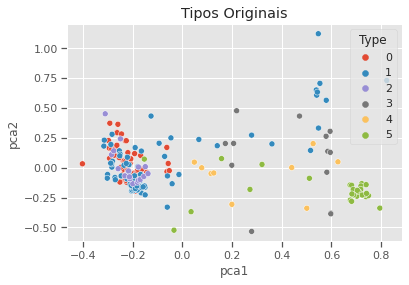

In [ ]:
sns.color_palette("Spectral", as_cmap=True)
sns.scatterplot(x="pca1", y="pca2", hue=data['Type'], data=results)
plt.title('Tipos Originais')
plt.show()

### Comparativo entre as cluterizações

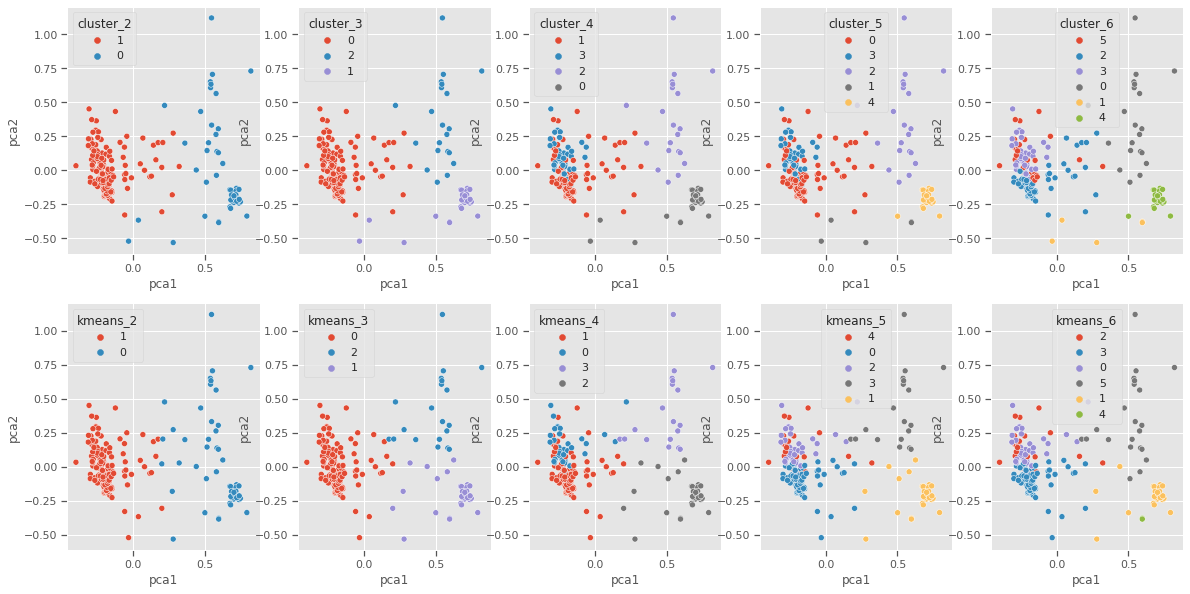

In [ ]:
fig, ax = plt.subplots(2,5,figsize=(20,10))

sns.scatterplot(x="pca1", y="pca2", hue=data['cluster_2'], data=results, ax=ax[0,0])
sns.scatterplot(x="pca1", y="pca2", hue=data['kmeans_2'], data=results, ax=ax[1,0])

sns.scatterplot(x="pca1", y="pca2", hue=data['cluster_3'], data=results, ax=ax[0,1])
sns.scatterplot(x="pca1", y="pca2", hue=data['kmeans_3'], data=results, ax=ax[1,1])

sns.scatterplot(x="pca1", y="pca2", hue=data['cluster_4'], data=results, ax=ax[0,2])
sns.scatterplot(x="pca1", y="pca2", hue=data['kmeans_4'], data=results, ax=ax[1,2])

sns.scatterplot(x="pca1", y="pca2", hue=data['cluster_5'], data=results, ax=ax[0,3])
sns.scatterplot(x="pca1", y="pca2", hue=data['kmeans_5'], data=results, ax=ax[1,3])

sns.scatterplot(x="pca1", y="pca2", hue=data['cluster_6'], data=results, ax=ax[0,4])
sns.scatterplot(x="pca1", y="pca2", hue=data['kmeans_6'], data=results, ax=ax[1,4])


plt.show()

O método que conseguiu encontrar grupos mais uniformes parece ser o do kmeans, em todos as variantes de k ele obteve grupos mais definidos e coesos. Isso pode ser observado com clareza ao se comparar o k=2 e k=3 para ambos os casos. O melhor agrupamento realmente aparenta ser o de k=2 utilizando o kmeans, nele os tipos 0, 1 e 2 (antes 1, 2 e 3) estão mais presentes no grupo 0, enquanto os tipos 3, 4 e 5 (anteriormente 5, 6 e 7) se concentram mais no grupo 1, no entanto ainda há casos onde alguns individuos com esses tipos estão no grupo 0, assim como em alguns casos individuos com o tipo 1 (antes 2) estão classificados no grupo 1.

### Matriz de confusão para k=6

Os grupos que o kmeans e a clusterização hierárquica encontraram quando o k é 6 não são iguais ou ao menos parecidos com as classes que foram definidas pela variável Type no dataset.

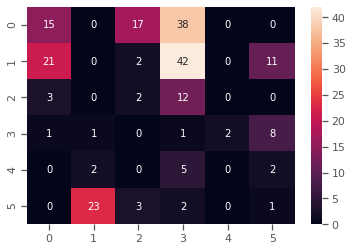

In [ ]:
df_cm = confusion_matrix(data['Type'], data['kmeans_6'])

sns.heatmap(df_cm, annot=True)

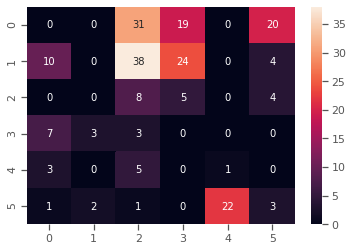

In [ ]:
df_cm = confusion_matrix(data['Type'], data['cluster_6'])

sns.heatmap(df_cm, annot=True)

As classes que mais se assimilam com os clusters criados foram a 4 ( no caso da clusterização hierárquica) e a 5 no caso do kmeans.